# Лабораторная работа 1

1. Найти в открытых источниках 2 временных ряда длиной 500-1000 измерений (про финансовые процессы) разного вида: с явными периодами (например, потребление энергии) и с броуновским движением (как биржевые котировки).
2. Реализовать (можно найти готовый, только хороший) алгоритм расчёта корреляционной размерности (и размерности вложения).
3. Средствами tSNE красиво изобразить фазовую траекторию системы, породившей каждый из рядов.
4. Сделать выводы о характере системы на основании исследованного.

<u>Ход работы:</u> 
1. [Выбор 2 временных ряда](#1)
2. [Реализация корреляционной размерности](#2)
3. [Фазовая траектория с помощью t-SNE](#3)
4. [Вывод](#4)

In [1]:
import matplotlib.pyplot as plt
from scripts import *
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import random

## <a id='1'>Выбор 2 временных ряда</a>


In [2]:
finance_ts, random_ts, dates = get_time_series_data()

Визуализируем

In [3]:
random_walk = generate_random_walk(840)
random_walk_time_series = MinMaxScaler().fit_transform(random_walk.reshape(-1, 1)).flatten()

Визуализируем теперь временные ряды

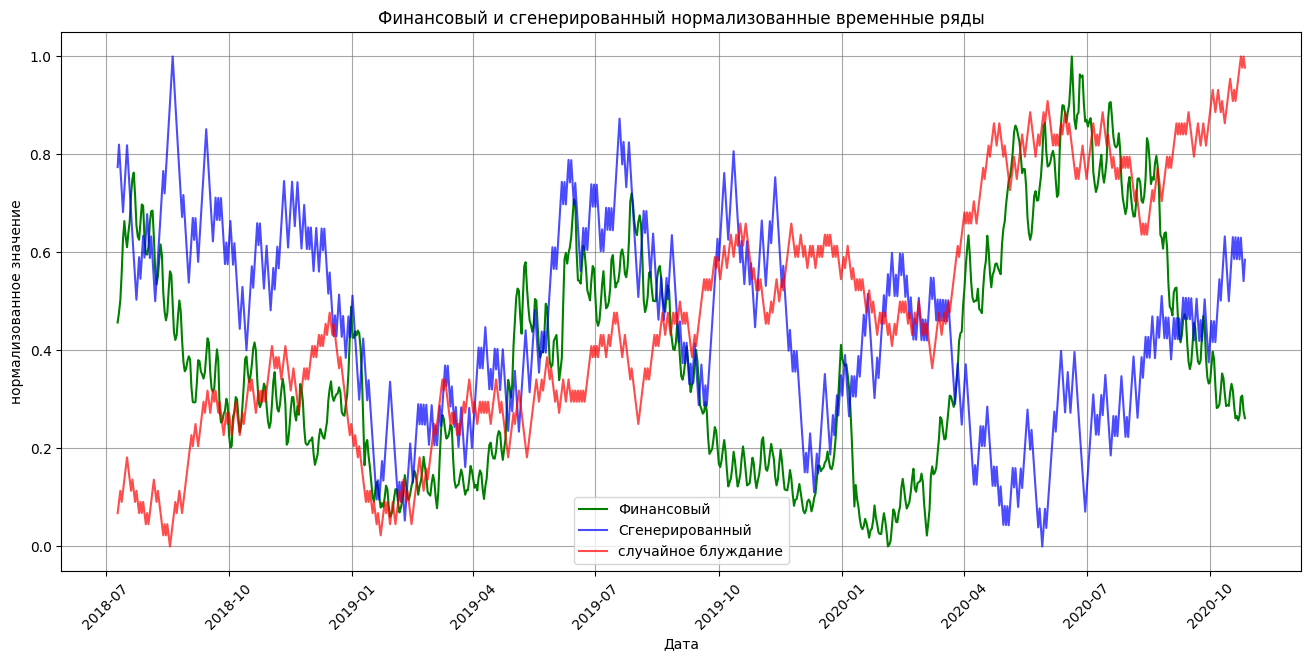

In [4]:
def draw_ts(finance_time_series,random_time_series,random_walk_time_series):
    plt.figure(figsize=(16,7))
    plt.rc('grid', linestyle="-", color='gray',alpha=0.7)
    plt.title('Финансовый и сгенерированный нормализованные временные ряды')
    plt.plot(dates,finance_time_series,color='green',label = 'Финансовый')
    plt.plot(dates, random_time_series,color='blue',label = 'Сгенерированный',alpha=0.7)
    plt.plot(dates, random_walk_time_series,color='red',label = 'случайное блуждание',alpha=0.7)

    plt.ylabel('нормализованное значение')
    plt.xlabel('Дата')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()

draw_ts(finance_ts,random_ts,random_walk_time_series)

## <a id='2'>Реализация корреляционной размерности</a>

**Выбор размерности вложения**:
Определение размерности вложения $m$, которая представляет количество измерений в каждом векторе вложенной траектории.

**Генерация вложенной траектории**:
Создание вложенной траектории путем формирования векторов с использованием временных сдвигов. Каждый вектор будет содержать $m$ элементов.
Пример вложенной траектории:
   
$$\mathbf{X}(t) = \left[ \begin{array}{c}
X(t) \\
X(t - 1) \\
\vdots \\
X(t - (m-1))
\end{array} \right]$$

**Расчет попарных расстояний**:
Вычисление попарных расстояния между всеми точками во вложенной траектории. Будет применяться евклидовая метрика.

**Подсчет близких точек**:
Задание порога $r$, который определяет, насколько близки точки должны быть друг к другу, чтобы считаться "близкими". Обычно этот порог выбирается эмпирически или с использованием методов, таких как "метод среднего расстояния".
Для каждой точки во вложенной траектории требуется подсчитать, сколько других точек находятся на расстоянии менее чем $r$ от нее.

**Расчет корреляционной размерности**:
Корреляционная размерность $D_2$ вычисляется как отношение суммы числа "близких" пар точек к общему числу точек во вложенной траектории:
$$
D_2 = \frac{2}{N(N-1)} \sum_{i=1}^{N} \sum_{j=i+1}^{N} \Theta(r - \|\mathbf{X}(i) - \mathbf{X}(j)\|)
$$
Где 
- $N$ - общее количество точек во вложенной траектории, 
- $\mathbf{X}(i)$ и $\mathbf{X}(j)$ - точки в траектории, 
- $\Theta(\cdot)$ - функция, которая равна 1, если аргумент меньше $r$, и 0 в противном случае.



Функция для расчета корреляционной размерности

In [5]:
embedding_dimension = 3  # Размерность вложения
time_delay = 1  # Задержка времени
epsilon = 0.1  # Порог расстояния

Рассчитаем корреляционные размерности

In [6]:
state_vectors_random = generate_state_vectors(random_ts, embedding_dimension, time_delay)
correlation_dimension_random = calculate_correlation_dimension(state_vectors_random, epsilon)

state_vectors_finance = generate_state_vectors(finance_ts, embedding_dimension, time_delay)
correlation_dimension_finance = calculate_correlation_dimension(state_vectors_finance, epsilon)

state_vectors_walk = generate_state_vectors(random_walk_time_series, embedding_dimension, time_delay)
correlation_dimension_walk = calculate_correlation_dimension(state_vectors_walk, epsilon)


Корреляционная размерность

In [7]:
print('finance:',round(correlation_dimension_finance,6))
print('random: ',round(correlation_dimension_random,6))
print('random walk:',round(correlation_dimension_walk,6))

finance: 0.241167
random:  0.230619
random walk: 0.269181


## <a id='3'>Фазовая траектория с помощью t-SNE</a>

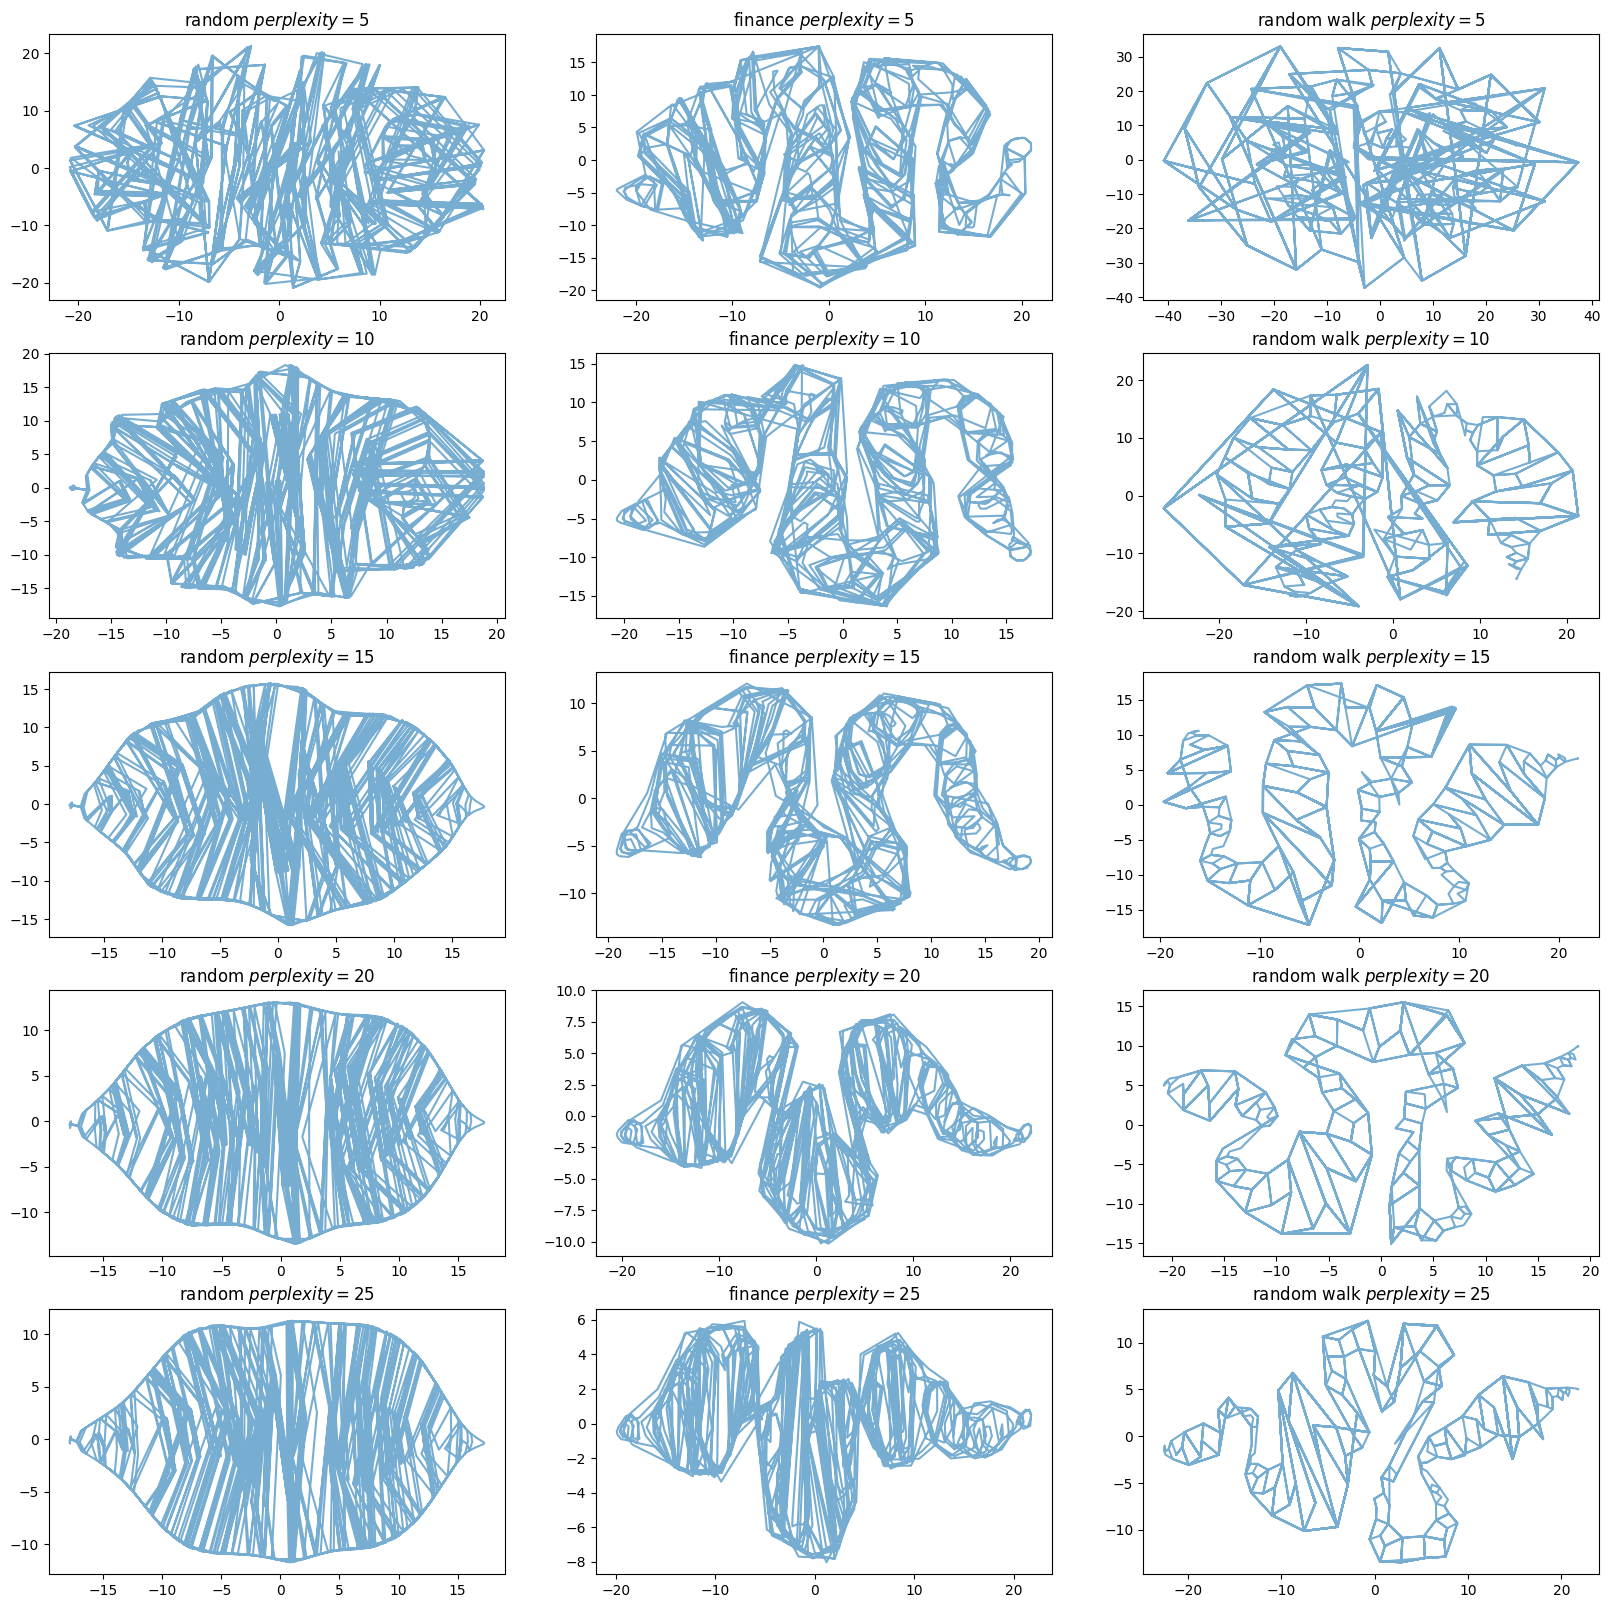

In [8]:
plt.figure(figsize=(20, 20))
perplexity_value = [5,10,15,20,25]

for i,p in enumerate(perplexity_value):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=300)
    tsne_random = tsne.fit_transform(state_vectors_random)
    tsne_finance = tsne.fit_transform(state_vectors_finance)
    tsne_walk = tsne.fit_transform(state_vectors_walk)

    plt.subplot(5, 3, 1+(3*i))
    plt.title(f"random $perplexity = {p}$")
    plt.plot(tsne_random[:, 0], tsne_random[:, 1],alpha = 0.6)

    plt.subplot(5, 3, 2+(3*i))
    plt.title(f"finance $perplexity = {p}$")
    plt.plot(tsne_finance[:, 0], tsne_finance[:, 1],alpha = 0.6)

    plt.subplot(5, 3, 3+(3*i))
    plt.title(f"random walk $perplexity = {p}$") 
    plt.plot(tsne_walk[:, 0], tsne_walk[:, 1],alpha = 0.6)
plt.show()

## <a id ='4'>Вывод</a>
t-SNE показывает разбиние фазовой траектории на 3 видимые группы